# Lecture 7: Convolutional Neural Networks Part 1

 - CIFAR-10 Dataset
 - Keras For Training A Neural Network On CIFAR-10: 10 Classes
 - Keras For Training A Convolutional Neural Network (CNN) On CIFAR-10: 10 Classes
 - Keras For Training A Convolutional Neural Network (CNN) on Fashion-MNIST: 10 Classes
 - Visualizing the feature maps of the hidden layers for the CNN trained on CIFAR-10

## Sources:

 - https://www.cs.toronto.edu/~kriz/cifar.html `CIFAR-10 Dataset`
 - https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
 - https://keras.io/layers/convolutional/
 - https://keras.io/layers/pooling/
 - https://keras.io/api/layers/convolution_layers/convolution2d/

#### Turn Off Keras & TF Messages:
TF_CPP_MIN_LOG_LEVEL:
 - 0 = all messages are logged (default behavior)
 - 1 = INFO messages are not printed
 - 2 = INFO and WARNING messages are not printed
 - 3 = INFO, WARNING, and ERROR messages are not printed

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#### Check GPU Availibility & Set Memory Limit:

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1792)]) # Alt: 1792 MB
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Import Libraries

In [3]:
from keras.datasets import cifar10
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model, model_to_dot
from tensorflow.keras.datasets import fashion_mnist

#### Define Functions For Plotting:

In [4]:
# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

def plotBothCurves(trainingAccuracy, trainingLoss, validAccuracy, validLoss):
    epochs = np.arange(trainingLoss.shape[0])
    epochsSaved = np.arange(validLoss.shape[0])
    #print(epochs)
    # 1st Subplot: Accuracy
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    plt.plot(epochsSaved, validAccuracy) # Saved Best Value
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    # 2nd Subplot: Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.plot(epochsSaved, validLoss)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot CIFAR-10 Data In Subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

def plotEverything(model_hist):
    trainAcc = np.array(model_hist.history['accuracy'])
    trainLoss = np.array(model_hist.history['loss'])
    validAcc = np.array(model_hist.history['val_accuracy'])
    validLoss = np.array(model_hist.history['val_loss'])

    plotBothCurves(trainAcc, trainLoss, validAcc, validLoss)

    trainScore = [trainAcc[-1], trainLoss[-1]]
    print(f'\nTraining Accuracy: {round(trainScore[0], 5) * 100} %')
    print(f'Training Loss: {round(trainScore[1], 4)}\n')

    valScore = [validAcc[-1], validLoss[-1]]
    print(f'\nValidation Accuracy: {round(valScore[0], 5) * 100} %')
    print(f'Validation Loss: {round(valScore[1], 4)}\n')

## Keras for training a Fully Connected Neural Network on CIFAR-10

#### Import Data:

 - Each of the 50,000 Images is 32 x 32 pixels x 3 RGB values
     - Each Image is 3D.

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

classes = np.arange(10)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


#### Randomize & Select 20% of Images For Validation:

In [6]:
num_train_img = x_train.shape[0]
train_ind = np.arange(0, num_train_img)
train_ind_s = np.random.permutation(train_ind)
print(train_ind)
print(train_ind_s, '\n')

x_train = x_train[train_ind_s,:,:,:]
y_train = y_train[train_ind_s]
print(x_train.shape)
print(y_train.shape, '\n')

x_val = x_train[0:int(0.2 * num_train_img),:,:,:]
y_val = y_train[0:int(0.2 * num_train_img)]
print(x_val.shape)
print(y_val.shape, '\n')

x_train = x_train[int(0.2 * num_train_img):,:,:]
y_train = y_train[int(0.2 * num_train_img):]
print(x_train.shape)
print(y_train.shape, '\n')

[    0     1     2 ... 49997 49998 49999]
[15177 46163 36221 ...  6882  4898 46758] 

(50000, 32, 32, 3)
(50000, 1) 

(10000, 32, 32, 3)
(10000, 1) 

(40000, 32, 32, 3)
(40000, 1) 



#### Plot 10 Images From Randomized Data:

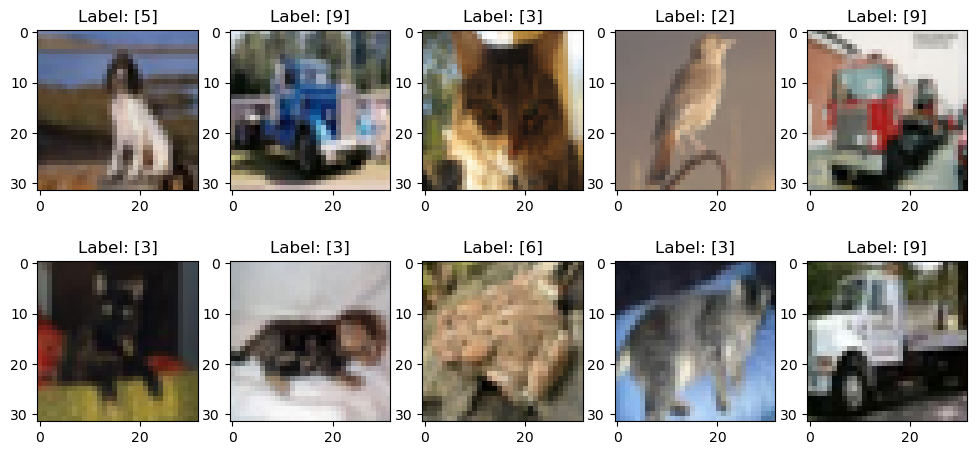

In [7]:
img_plt(x_train[0:10,:,:,:], y_train[0:10]) # plot the images

#### Scaling The Images to $ [0, \ 1] $:

In [8]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
x_test /= 255

#### Convert Class Vectors to Binary Class Matrices:

In [9]:
y_train_c = to_categorical(y_train, len(classes))
y_val_c = to_categorical(y_val, len(classes))
y_test_c = to_categorical(y_test, len(classes))

#### Flatten The Images:

 - Makes a 1 dimensional Array Of All Features.
 - Note The Extra Dimension.

In [10]:
x_train_f = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3]))
x_val_f = np.reshape(x_val, (x_val.shape[0], x_val.shape[1] * x_val.shape[2] * x_val.shape[3]))
x_test_f = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3]))

#### Build The Network:

 - Input Dimensions: $ \ 32 \times \ 32 \times 3 \ = 3072 $

In [11]:
model1 = Sequential()
model1.add(Dense(input_dim = x_train_f.shape[1], units=3072, activation='relu')) # input layer & 1st Hidden Layer
model1.add(Dense(units=4096, activation='relu')) # 2nd Hidden Layer
model1.add(Dense(units=1024, activation='relu')) # 3rd Hidden Layer
model1.add(Dense(units=len(classes), activation='softmax')) # Output Layer
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3072)              9440256   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              12587008  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
Total params: 26,232,842
Trainable params: 26,232,842
Non-trainable params: 0
_________________________________________________________________


#### Compile & Fit The Network:

Epoch 1/20
2500/2500 [==============================] - 39s 15ms/step - loss: 2.1572 - accuracy: 0.2535 - val_loss: 1.8098 - val_accuracy: 0.3421
Epoch 2/20
2500/2500 [==============================] - 38s 15ms/step - loss: 1.8056 - accuracy: 0.3472 - val_loss: 1.7377 - val_accuracy: 0.3763
Epoch 3/20
2500/2500 [==============================] - 38s 15ms/step - loss: 1.7367 - accuracy: 0.3749 - val_loss: 1.7256 - val_accuracy: 0.3747
Epoch 4/20
2500/2500 [==============================] - 38s 15ms/step - loss: 1.7043 - accuracy: 0.3881 - val_loss: 1.7215 - val_accuracy: 0.3795
Epoch 5/20
2500/2500 [==============================] - 38s 15ms/step - loss: 1.6770 - accuracy: 0.3945 - val_loss: 1.6683 - val_accuracy: 0.4003
Epoch 6/20
2500/2500 [==============================] - 38s 15ms/step - loss: 1.6570 - accuracy: 0.3994 - val_loss: 1.6904 - val_accuracy: 0.3842
Epoch 7/20
2500/2500 [==============================] - 38s 15ms/step - loss: 1.6296 - accuracy: 0.4111 - val_loss: 1.6375 -

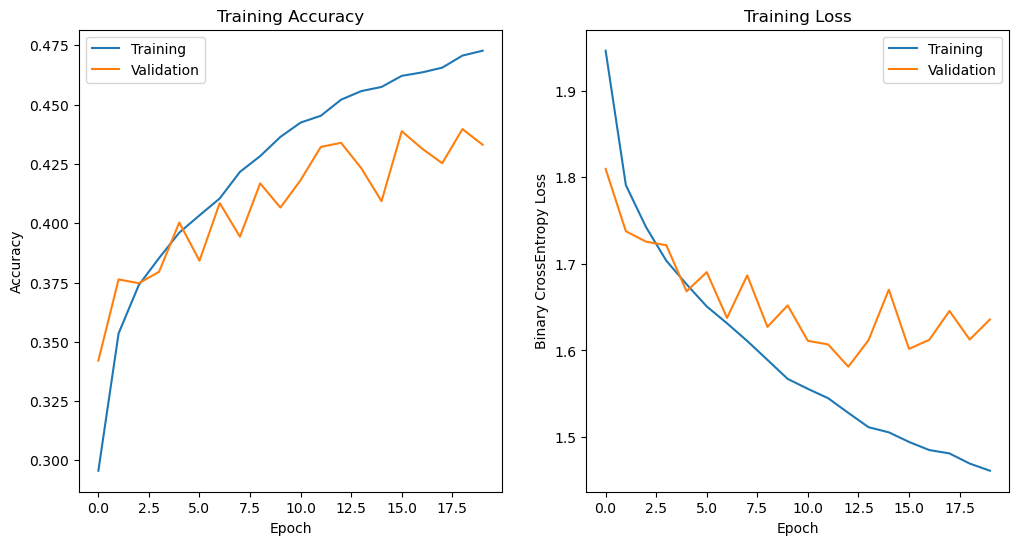


Training Accuracy: 47.275 %
Training Loss: 1.4609


Validation Accuracy: 43.309999999999995 %
Validation Loss: 1.6357



In [12]:
save_path1 = '../assets/Lecture7/model1_ckpt.h5'
callbacks_save1 = ModelCheckpoint(save_path1, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

opt1 = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='categorical_crossentropy', optimizer=opt1, metrics=['accuracy'])
history1 = model1.fit(x_train_f, y_train_c, epochs = 20, batch_size = 16, verbose = 1, validation_data=(x_val_f, y_val_c), callbacks=[callbacks_save1])

plotEverything(history1)

#### Load Best Model & Evaluate On Held Out Samples:

In [14]:
model1a = load_model(save_path1)

score1a = model1a.evaluate(x_test_f, y_test_c)
print(f'\nTotal Loss On Test Set: {score1a[0]}')
print(f'Accuracy On Test Set: {score1a[1] * 100} %\n')

313/313 [==============================] - 1s 4ms/step - loss: 1.5617 - accuracy: 0.4491

Total Loss On Test Set: 1.5617443323135376
Accuracy On Test Set: 44.9099987745285 %



#### What's The Problem?

 - Total Parameters = 26,224,648 Is A Very Large Model!
     - Takes A VERY Long Time To Compile & Fit, Even Using GPU.
 - Low Performance With Validation & Test Data.

## Keras For Training A Convolutional Neural Network (CNN) Using CIFAR-10 Dataset

 - 10 Classes
 - Main Advantages:
     - CNN learns distinctive features throughout convolutional filters.
     - Efficient due to lower number of parameters.
     - Parameter sharing and pooling layers.
     - No need to flatten the images.

#### Define The Model:

In [12]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model2.add(Dense(units=512, activation='relu'))
model2.add(Dropout(0.5)) # Helps to reduce overfitting
model2.add(Dense(units=len(classes), activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)       

#### Plot CNN Model Image:

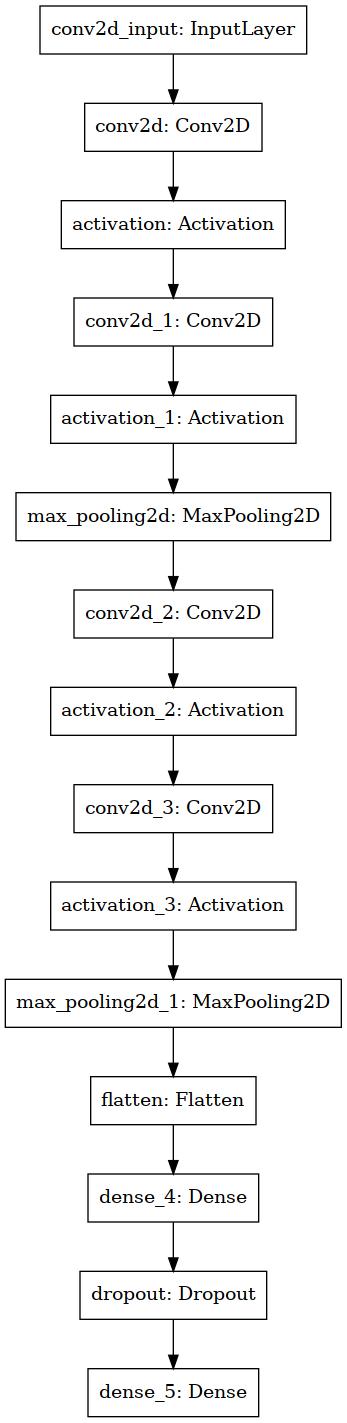

In [13]:
plot_model(model2, to_file='../assets/Lecture7/model2_CNN.png')

#### Compiling & Training The CNN:

 - Create a checkpoint to save the best model based on lowest validation loss

In [17]:
save_path2 = '../assets/Lecture7/model2_ckpt.h5'
callbacks_save2 = ModelCheckpoint(save_path2, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

opt2 = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])
history2 = model2.fit(x_train, y_train_c, batch_size=16, epochs=20, verbose=1, validation_data=(x_val, y_val_c), callbacks=[callbacks_save2])

Epoch 1/20
2500/2500 [==============================] - 18s 5ms/step - loss: 1.7492 - accuracy: 0.3541 - val_loss: 1.0956 - val_accuracy: 0.6075
Epoch 2/20
2500/2500 [==============================] - 11s 5ms/step - loss: 1.0845 - accuracy: 0.6159 - val_loss: 0.9250 - val_accuracy: 0.6771
Epoch 3/20
2500/2500 [==============================] - 11s 5ms/step - loss: 0.8836 - accuracy: 0.6891 - val_loss: 0.8550 - val_accuracy: 0.6982
Epoch 4/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.7504 - accuracy: 0.7365 - val_loss: 0.8428 - val_accuracy: 0.7069
Epoch 5/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6370 - accuracy: 0.7770 - val_loss: 0.8784 - val_accuracy: 0.7017
Epoch 6/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5515 - accuracy: 0.8069 - val_loss: 0.7914 - val_accuracy: 0.7382
Epoch 7/20
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4889 - accuracy: 0.8283 - val_loss: 0.8300 - val_ac

#### Plot Training Loss & Accuracy:

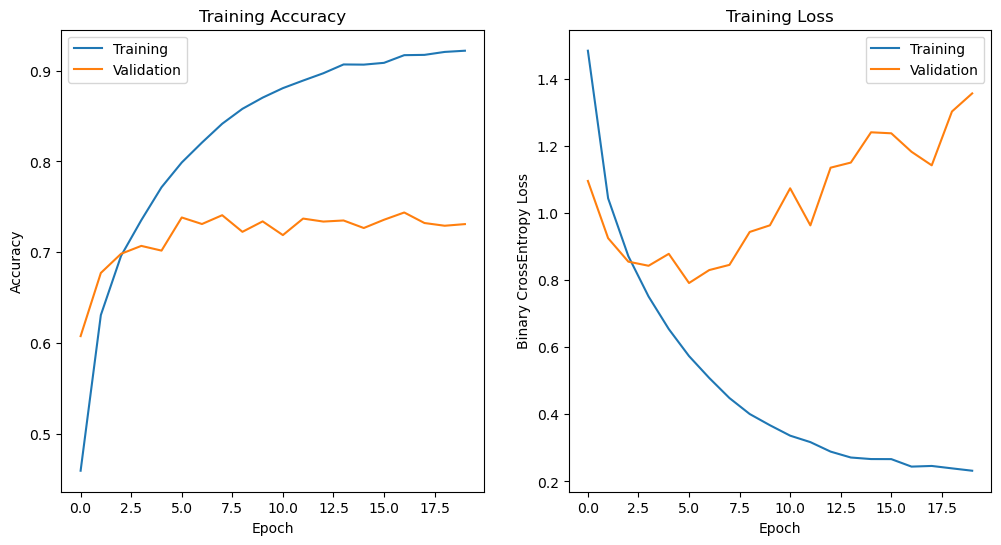


Training Accuracy: 92.193 %
Training Loss: 0.2319


Validation Accuracy: 73.09 %
Validation Loss: 1.3566



In [18]:
plotEverything(history2)

#### Load Best Model & Evaluate On Held Out Samples:

In [19]:
model2a = load_model(save_path2)

score2a = model2a.evaluate(x_test, y_test_c)
print(f'\nTotal Loss On Test Set: {score2a[0]}')
print(f'Accuracy On Test Set: {score2a[1] * 100} %\n')

313/313 [==============================] - 4s 4ms/step - loss: 0.7923 - accuracy: 0.7439

Total Loss On Test Set: 0.7923386693000793
Accuracy On Test Set: 74.39000010490417 %



#### Note That The CNN Overfits The Training Data In This Case

 - This is evidenced by the continually increasing Validation Loss after Epoch 5.
 - The Validation Accuracy and Test Set Accuracy are also low.

## Keras for training a Convolutional Neural Network (CNN) on Fashion-MNIST

 - 10 Classes
 - Fashion MNIST Images are 28 x 28 pixel gray-scale images.
 - Labels: 
     - 0: T-Shirt, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat,
     - 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle Boot

#### Load Fashion-MNIST Data:

In [20]:
(x_train_fash, y_train_fash), (x_test_fash, y_test_fash) = fashion_mnist.load_data()

classes = np.arange(10)
print(x_train_fash.shape)
print(y_train_fash.shape, '\n')
print(x_test_fash.shape)
print(y_test_fash.shape)

(60000, 28, 28)
(60000,) 

(10000, 28, 28)
(10000,)


#### Randomize & Select 20% of Images For Validation:

In [21]:
num_train_fash = x_train_fash.shape[0]
train_ind_fash = np.arange(0, num_train_fash)
train_ind_fash_s = np.random.permutation(train_ind_fash)
print(train_ind_fash)
print(train_ind_fash_s, '\n')

x_train_fash = x_train_fash[train_ind_fash_s,:,:]
y_train_fash = y_train_fash[train_ind_fash_s]
print(x_train_fash.shape)
print(y_train_fash.shape, '\n')

x_val_fash = x_train_fash[0:int(0.2 * num_train_fash),:,:]
y_val_fash = y_train_fash[0:int(0.2 * num_train_fash)]
print(x_val_fash.shape)
print(y_val_fash.shape, '\n')

x_train_fash = x_train_fash[int(0.2 * num_train_fash):,:,:]
y_train_fash = y_train_fash[int(0.2 * num_train_fash):]
print(x_train_fash.shape)
print(y_train_fash.shape, '\n')

[    0     1     2 ... 59997 59998 59999]
[37985 34675 31021 ... 40491 28337 47285] 

(60000, 28, 28)
(60000,) 

(12000, 28, 28)
(12000,) 

(48000, 28, 28)
(48000,) 



#### Plot 10 Images From Randomized Data:

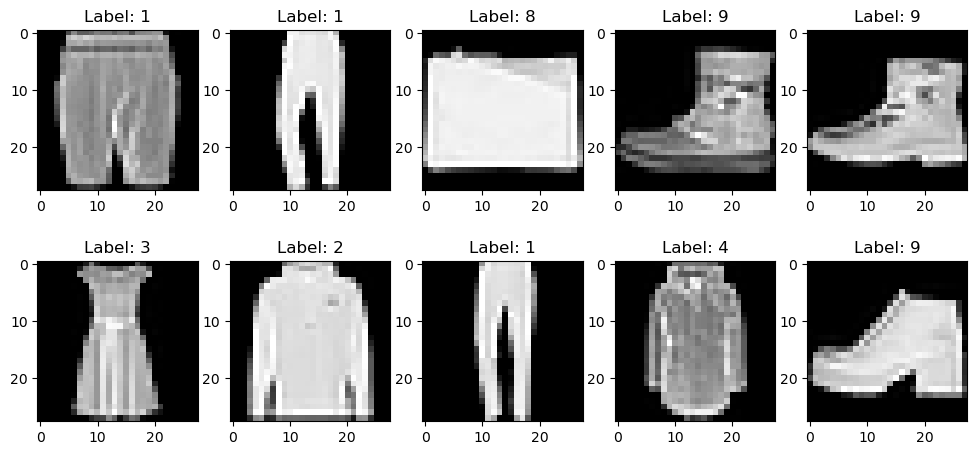

In [22]:
img_plt(x_train_fash[0:10,:,:], y_train_fash[0:10]) # plot the images

#### Expand Dimensions for Use With Keras Models

 - Add the 4th dimension for grayscale images as required by Keras
 - $ (n, \ 28, \ 28) \ \mathrm{to} \ (n, \ 28, \ 28, \ 1) $

In [23]:
x_train_fash = np.expand_dims(x_train_fash, axis=3)
x_val_fash = np.expand_dims(x_val_fash, axis=3)
x_test_fash = np.expand_dims(x_test_fash, axis=3)

print(x_train_fash.shape)
print(x_val_fash.shape)
print(x_test_fash.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)


#### Convert Class Vectors to Binary Class Matrices:

In [24]:
y_train_fash_c = to_categorical(y_train_fash, len(classes))
y_val_fash_c = to_categorical(y_val_fash, len(classes))
y_test_fash_c = to_categorical(y_test_fash, len(classes))

#### Define The Model:

In [25]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train_fash.shape[1:]))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model3.add(Dense(units=512, activation='relu'))
model3.add(Dropout(0.5)) # Helps to reduce overfitting
model3.add(Dense(units=len(classes), activation='softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 64)       

#### Compile and Fit The Model:

 - Create A Checkpoint to save the best model with lowest validation loss

In [26]:
save_path3 = '../assets/Lecture7/model3_ckpt.h5'
callbacks_save3 = ModelCheckpoint(save_path3, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

opt3 = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='categorical_crossentropy', optimizer=opt3, metrics=['accuracy'])
history3 = model3.fit(x_train_fash, y_train_fash_c, batch_size=16, epochs=20, verbose=1, validation_data=(x_val_fash, y_val_fash_c), callbacks=[callbacks_save3])

Epoch 1/20
3000/3000 [==============================] - 18s 4ms/step - loss: 1.0378 - accuracy: 0.7798 - val_loss: 0.3144 - val_accuracy: 0.8828
Epoch 2/20
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3347 - accuracy: 0.8794 - val_loss: 0.2761 - val_accuracy: 0.8952
Epoch 3/20
3000/3000 [==============================] - 13s 4ms/step - loss: 0.2969 - accuracy: 0.8903 - val_loss: 0.2715 - val_accuracy: 0.8992
Epoch 4/20
3000/3000 [==============================] - 14s 5ms/step - loss: 0.2768 - accuracy: 0.8984 - val_loss: 0.2634 - val_accuracy: 0.9057
Epoch 5/20
3000/3000 [==============================] - 14s 5ms/step - loss: 0.2503 - accuracy: 0.9069 - val_loss: 0.2654 - val_accuracy: 0.9062
Epoch 6/20
3000/3000 [==============================] - 14s 5ms/step - loss: 0.2333 - accuracy: 0.9145 - val_loss: 0.2672 - val_accuracy: 0.9061
Epoch 7/20
3000/3000 [==============================] - 14s 5ms/step - loss: 0.2268 - accuracy: 0.9182 - val_loss: 0.2553 - val_ac

#### Plot Training Loss & Accuracy:

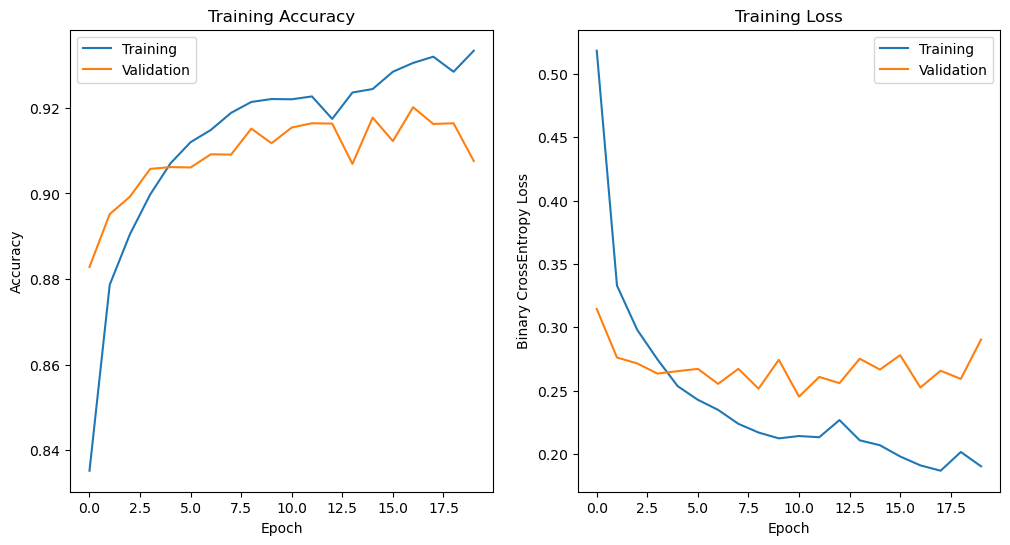


Training Accuracy: 93.338 %
Training Loss: 0.1902


Validation Accuracy: 90.75800000000001 %
Validation Loss: 0.2903



In [27]:
plotEverything(history3)

#### Use Best Model To Evaluate The Test Data Set:

In [29]:
model3a = load_model(save_path3)

score3a = model3a.evaluate(x_test_fash, y_test_fash_c)
print(f'\nTotal Loss On Testing Set: {score3a[0]}')
print(f'Accuracy On Testing Set: {score3a[1] * 100} %\n')

313/313 [==============================] - 1s 2ms/step - loss: 0.2732 - accuracy: 0.9114

Total Loss On Testing Set: 0.2732454836368561
Accuracy On Testing Set: 91.14000201225281 %



## Visualization Of Hidden Layer Feature Maps:

 - For the CNN Trained on CIFAR-10

#### Select An Image & A Layer:

conv2d


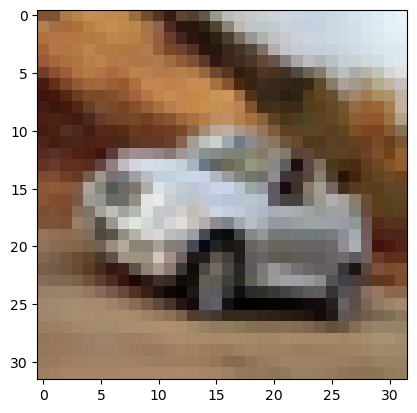

In [30]:
img_tensor = np.expand_dims(x_train[0,:,:,:], axis=0)
plt.figure()
plt.imshow(img_tensor[0])

layer_names = 'conv2d'
print(model2.layers[0].name)

layer_outputs = model2.layers[0].output
activation_model = Model(inputs=model2.input, outputs=layer_outputs)

#### Use New Model On Any Image To Get Feature Maps Using `predict()` Function:

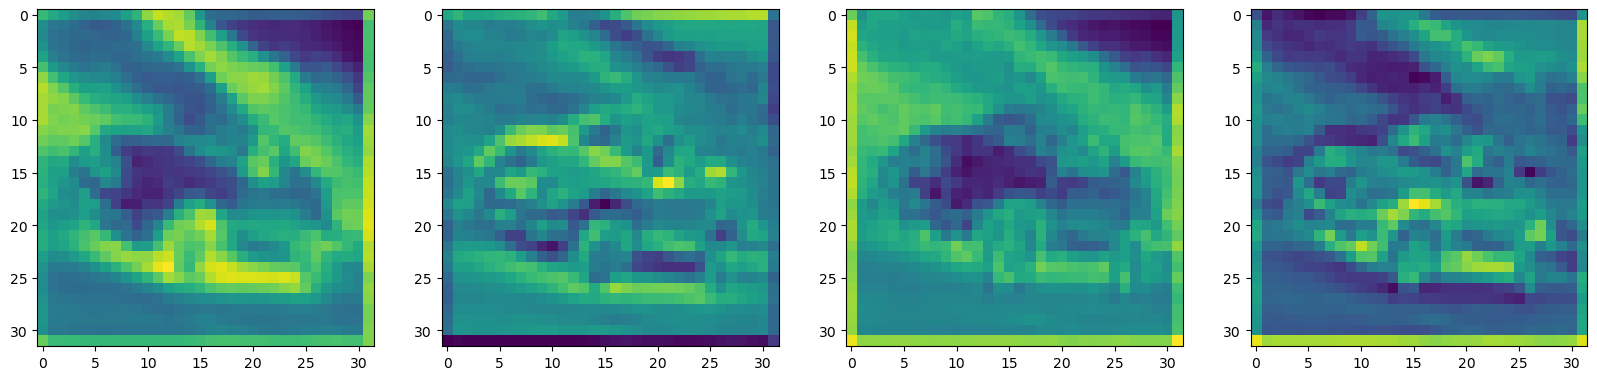

In [31]:
intermediate_activations = activation_model.predict(img_tensor)

plt.figure(figsize = (20, 200))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(intermediate_activations[0,:,:,i])
plt.show()

#### Import Weights Of Hidden Filters:

 - Layer Index should be specified based on network architecture

##### First Convolutional Layer:

Shape Of Convolutional Filter Weights: (3, 3, 3, 32)
Shape Of Bias Weights: (32,)

Weight Matrix For 1st Convolutional Layer:

[[ 0.07901599  0.0345401  -0.0341917 ]
 [-0.08234446 -0.06261428 -0.10859294]
 [-0.10183613  0.08723465 -0.05125628]]



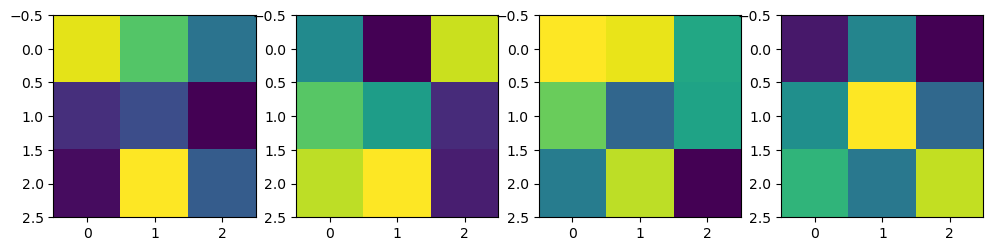

In [32]:
weights2 = model2.layers[0].get_weights()
print(f'Shape Of Convolutional Filter Weights: {weights2[0].shape}')
print(f'Shape Of Bias Weights: {weights2[1].shape}\n')

print(f'Weight Matrix For 1st Convolutional Layer:\n\n{weights2[0][:,:,0,0]}\n')

plt.figure(figsize=(12, 3))
for i in range (4):
    plt.subplot(1, 4, i+1)
    plt.imshow(weights2[0][:,:,0,i])
plt.show()

##### Second Convolutional Layer:

Shape Of Convolutional Filter Weights: (3, 3, 32, 32)
Shape Of Bias Weights: (32,)

Weight Matrix For 1st Convolutional Layer:

[[ 0.10076597  0.07072686 -0.05276779]
 [ 0.08454284 -0.08074763  0.06262279]
 [-0.09348201 -0.07366931 -0.00976904]]



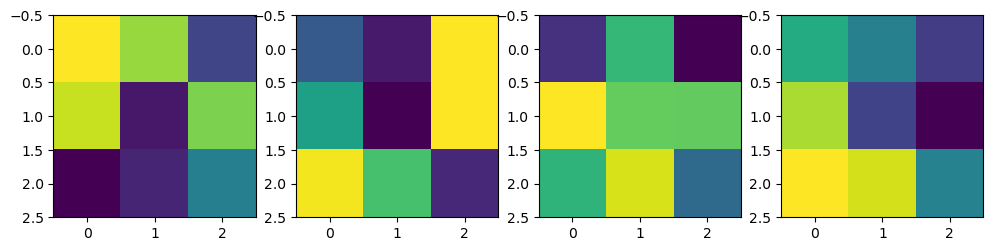

In [33]:
weights2a = model2.layers[2].get_weights()
print(f'Shape Of Convolutional Filter Weights: {weights2a[0].shape}') # Weights For Filters
print(f'Shape Of Bias Weights: {weights2a[1].shape}\n') # Weights For Biases

print(f'Weight Matrix For 1st Convolutional Layer:\n\n{weights2a[0][:,:,0,0]}\n')

plt.figure(figsize=(12, 3))
for i in range (4):
    plt.subplot(1, 4, i+1)
    plt.imshow(weights2a[0][:,:,0,i])
plt.show()

#### Display Feature Maps:

(40000, 32, 32, 3)
(40000, 32, 32, 3) 



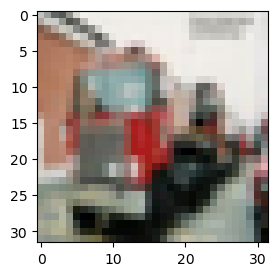

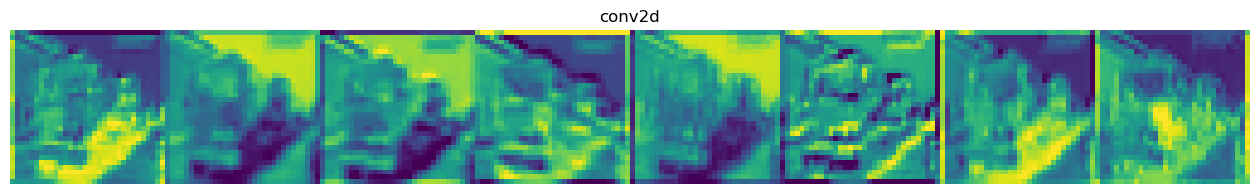

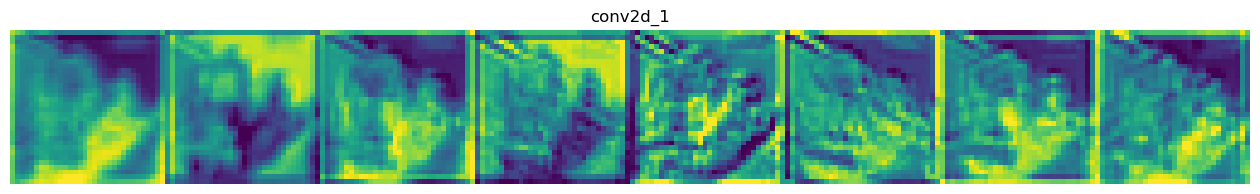

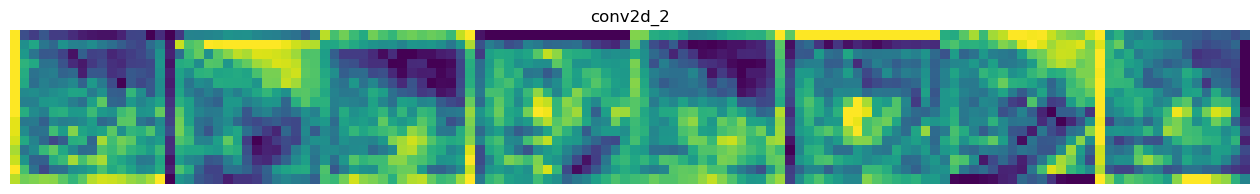

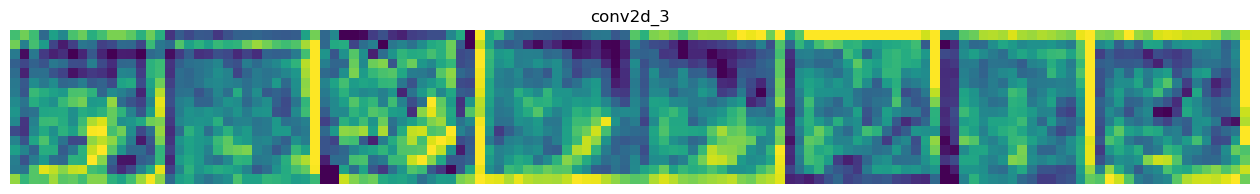

In [34]:
print(x_train.shape)
img_tensor2 = np.expand_dims(x_train[4,:,:,:], axis=0)
print(x_train.shape, '\n')

plt.figure(figsize=(3, 3))
plt.imshow(img_tensor2[0])
plt.show()

layer_names2 = ['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3']

layer_outputs2 = [layer.output for layer in model2.layers if layer.name in layer_names2]
activation_model2 = Model(inputs=model2.input, outputs=layer_outputs2)
intermediate_activations2 = activation_model2.predict(img_tensor2)

print('\n')
img_per_row = 8
max_imgs = 8

for layer_name, layer_activation in zip(layer_names2, intermediate_activations2):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_imgs)

    # Feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # Tile Activation Channels in a Matrix
    n_cols = n_features // img_per_row
    display_grid = np.zeros((size * n_cols, img_per_row * size))

    for column in range(n_cols):
        for row in range(img_per_row):
            channel_image = layer_activation[0,:,:, column * img_per_row + row]

            # Post Process the feature to make it visually palatable:
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[column * size : (column + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid

    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()